In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import os 
from pathlib import Path

import utils.utils as utils
import utils.models as models

from tensorflow.keras import callbacks
PATH = str(Path(os.getcwd()).parent)

figsize=(14, 5)

# Improve usage of unsupervised data for the definition of RUL-based maintenance policies

## Data Loading and Preparation

In [2]:
path = os.path.join(PATH, 'data')

data = utils.load_cmapss_data(path, 'train_*.txt')

# Identify input columns
dt_in = list(data.columns[3:-1])


In [3]:
data_by_src = utils.split_by_field(data, field='src')

dt = data_by_src['train_FD004']
dt[dt_in] = dt[dt_in].astype(np.float32)

dt.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD004,461,1,42.004902,0.8400,100.0,445.000000,549.679993,1343.430054,1112.930054,...,2387.989990,8074.830078,9.3335,0.02,330.0,2212.0,100.00,10.620000,6.3670,320
1,train_FD004,461,2,20.002001,0.7002,100.0,491.190002,606.070007,1477.609985,1237.500000,...,2387.729980,8046.129883,9.1913,0.02,361.0,2324.0,100.00,24.370001,14.6552,319
2,train_FD004,461,3,42.003799,0.8409,100.0,445.000000,548.950012,1343.119995,1117.050049,...,2387.969971,8066.620117,9.4007,0.02,329.0,2212.0,100.00,10.480000,6.4213,318
3,train_FD004,461,4,42.000000,0.8400,100.0,445.000000,548.700012,1341.239990,1118.030029,...,2388.020020,8076.049805,9.3369,0.02,328.0,2212.0,100.00,10.540000,6.4176,317
4,train_FD004,461,5,25.006300,0.6207,60.0,462.540009,536.099976,1255.229980,1033.589966,...,2028.079956,7865.799805,10.8366,0.02,305.0,1915.0,84.93,14.030000,8.6754,316


In [4]:
trs_ratio = 0.03 # Ratio of supervised experiments
tru_ratio = 0.75 # Ration of supervised and unsupervised data

np.random.seed(42)
machines = dt.machine.unique()
np.random.shuffle(machines)

sep_trs = int(trs_ratio * len(machines))
sep_tru = int(tru_ratio * len(machines))

trs_mcn = list(machines[:sep_trs])
tru_mcn = list(machines[sep_trs:sep_tru])
ts_mcn = list(machines[sep_tru:])

Let's chek how many machines we have in each group:

In [5]:
print(f'Num. machine: {len(trs_mcn)} (supervised), {len(tru_mcn)} (unsupervised), {len(ts_mcn)} (test)')

Num. machine: 7 (supervised), 179 (unsupervised), 63 (test)


we can split the dataset according to this machine groups:

In [5]:
tr, ts = utils.partition_by_machine(dt, trs_mcn + tru_mcn)
trs, tru = utils.partition_by_machine(tr, trs_mcn)

Let's check the number of examples for each group:

In [7]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 1376 (supervised), 44009 (unsupervised), 15864 (test)


Now we can standardize and normalize the input data.

In [6]:
# standardize

trmean = tr[dt_in].mean()
trstd = tr[dt_in].std().replace(to_replace=0, value=1) # handle static fields

ts_s = ts.copy()
ts_s[dt_in] = (ts_s[dt_in] - trmean) / trstd
tr_s = trs.copy()
tr_s[dt_in] = (tr_s[dt_in] - trmean) / trstd
trs_s = trs.copy()
trs_s[dt_in] = (trs_s[dt_in] - trmean) / trstd
tru_s = tru.copy()
tru_s[dt_in] = (tru_s[dt_in] - trmean) / trstd


# normalize

trmaxrul = tr['rul'].max()

ts_s['rul'] = ts['rul'] / trmaxrul 
tr_s['rul'] = tr['rul'] / trmaxrul 
trs_s['rul'] = trs['rul'] / trmaxrul
tru_s['rul'] = tru['rul'] / trmaxrul

In [17]:
nn = models.MLPRegressor(input_shape=len(dt_in), hidden=[32, 32])
nn.compile(optimizer='Adam', loss='mse')

history = nn.fit(trs_s[dt_in], trs_s['rul'], batch_size=32, epochs=20, verbose=1)

Epoch 1/20
43/43 [==============================] - 1s 1ms/step - loss: 0.0217
Epoch 2/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 3/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 4/20
43/43 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 5/20
43/43 [==============================] - 0s 1ms/step - loss: 0.0093
Epoch 6/20
43/43 [==============================] - 0s 1ms/step - loss: 0.0088
Epoch 7/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 8/20
43/43 [==============================] - 0s 1ms/step - loss: 0.0083
Epoch 9/20
43/43 [==============================] - 0s 974us/step - loss: 0.0076
Epoch 10/20
43/43 [==============================] - 0s 1ms/step - loss: 0.0084
Epoch 11/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 12/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 13/20
43/43 [============================

## Domain Knowledge as Constraints

We start by preparing a bit more the unsupervised data.

* First, we _remove the end_ of the unsupervised data sequences
* This simulate the fact that the machines are still operating

In [7]:
tru_s_by_m = utils.split_by_field(tru_s, 'machine')
np.random.seed(42)
for mcn, tmp in tru_s_by_m.items():
    cutoff = int(np.random.randint(10, 50, 1))
    tru_s_by_m[mcn] = tmp.iloc[:-cutoff]
tru_st = pd.concat(tru_s_by_m.values())

Then we assign an invalid value to the RUL for unsupervised data.

In [8]:
trsu_s = pd.concat((trs_s, tru_st))
trsu_s.loc[tru_st.index, 'rul'] = -1

In [11]:
nn2 = models.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32])
batch_gen = models.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
nn2.compile(optimizer='Adam', run_eagerly=False)
history = nn2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)

Epoch 1/20
1350/1350 [==============================] - 12s 8ms/step - loss: 0.0017 - mse: 0.0017 - cst: 0.0017
Epoch 2/20
1350/1350 [==============================] - 11s 8ms/step - loss: 5.2290e-04 - mse: 0.0017 - cst: 5.2290e-04
Epoch 3/20
1350/1350 [==============================] - 12s 9ms/step - loss: 4.9881e-04 - mse: 0.0015 - cst: 4.9881e-04
Epoch 4/20
1350/1350 [==============================] - 13s 9ms/step - loss: 4.4731e-04 - mse: 0.0013 - cst: 4.4731e-04
Epoch 5/20
1350/1350 [==============================] - 11s 8ms/step - loss: 4.1238e-04 - mse: 0.0012 - cst: 4.1238e-04
Epoch 6/20
1350/1350 [==============================] - 10s 8ms/step - loss: 4.1563e-04 - mse: 0.0011 - cst: 4.1563e-04
Epoch 7/20
1350/1350 [==============================] - 10s 8ms/step - loss: 4.0186e-04 - mse: 0.0010 - cst: 4.0186e-04
Epoch 8/20
1350/1350 [==============================] - 15s 11ms/step - loss: 3.9020e-04 - mse: 0.0010 - cst: 3.9020e-04
Epoch 9/20
1350/1350 [=========================

In [9]:
nn3 = models.LagDualRULRegressor(input_shape=len(dt_in), maxrul=trmaxrul, hidden=[32, 32])
batch_gen = models.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
nn3.compile(optimizer='Adam', run_eagerly=False)
history = nn3.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)

Epoch 1/20
1350/1350 [==============================] - 11s 8ms/step - loss: -0.0175 - mse: 0.0017 - cst: 0.0174
Epoch 2/20
1350/1350 [==============================] - 11s 8ms/step - loss: -0.0501 - mse: 0.0019 - cst: 0.0142
Epoch 3/20
1350/1350 [==============================] - 10s 7ms/step - loss: -0.0815 - mse: 0.0016 - cst: 0.0134
Epoch 4/20
1350/1350 [==============================] - 11s 8ms/step - loss: -0.1137 - mse: 0.0015 - cst: 0.0132
Epoch 5/20
1350/1350 [==============================] - 11s 8ms/step - loss: -0.1460 - mse: 0.0014 - cst: 0.0131
Epoch 6/20
1350/1350 [==============================] - 11s 8ms/step - loss: -0.1784 - mse: 0.0013 - cst: 0.0130
Epoch 7/20
1350/1350 [==============================] - 15s 11ms/step - loss: -0.2105 - mse: 0.0013 - cst: 0.0129
Epoch 8/20
1350/1350 [==============================] - 12s 9ms/step - loss: -0.2425 - mse: 0.0013 - cst: 0.0129
Epoch 9/20
1350/1350 [==============================] - 14s 11ms/step - loss: -0.2751 - mse: 0.

## Evaluation


### Baseline Approach

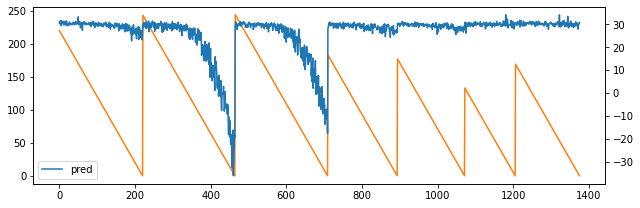

In [29]:
trs_pred = nn.predict(trs_s[dt_in]).ravel() * trmaxrul
stop = 1400 
utils.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

#### Unsupervised data

In [ ]:
tru_pred = nn.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

#### Test set

In [ ]:
ts_pred = nn.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

#### Cost Results

In [ ]:
failtimes = dt.groupby('machine')['cycle'].max() 
safe_interval, maintenance_cost = failtimes.min(), failtimes.max()

cmodel = models.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-10, 30)
trs_thr = utils.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')